# Setup

## Download data

In [1]:
#!kaggle competitions download -c bike-sharing-demand
#!unzip bike-sharing-demand.zip -d ./dataset

## Evaluations
- Submissions are evaluated by the Root Mean Squared Logarithmic Error(RMSLE).
- Calculated as 

<center>
$\text{RMSLE} = \sqrt{ \frac{1}{n}\Sigma_{i=1}^{n}{(\text{log}(p_i+1) - \text{log}(a_i+1))^2} }$
</center>

## Formats

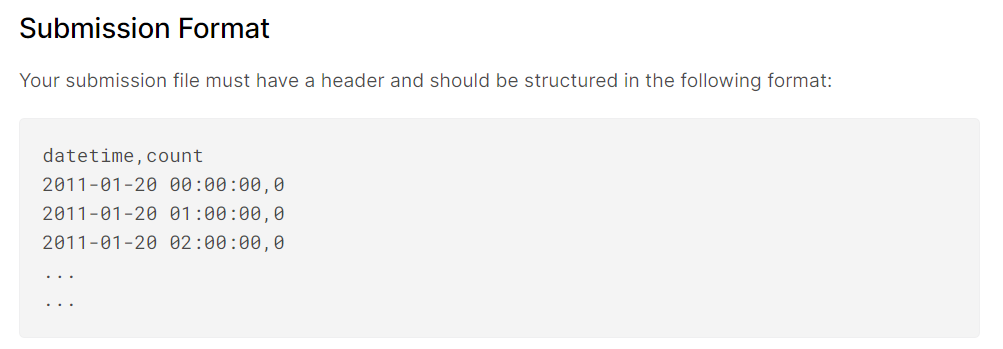

1시간 간격으로 되어있고 대여 수량은 모두 0으로 초기화되어있음 

# EDA 

## library 

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline 

plt.rcParams['font.family'] = 'Malgun Gothic'

## 변수 설명

- datetime : 기록 일시(1시간 간격)
- season : 계절(1 ~ 4 : 봄 ~ 겨울)
- holiday : 공휴일 여부
- workingday : 근무일 여부
    - 주말이 아니고 공휴일이 아니면 근무일이라고 판단할 수 있음
- weather : 날씨
    - 1 : 맑음
    - 2 : 옅은 안개, 약간 흐림
    - 3 : 약간의 눈, 약간의 비와 천둥번개, 흐림
    - 4 : 폭우와 천둥번개, 눈과 짙은 안개
- temp : 온도
- atemp : 체감 온도
- humidity : 습도
- windspeed : 풍속
- casual : 비회원 사용자
- registered : 회원 사용자
- count : 대여 수량

## load data

In [3]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submission = pd.read_csv('dataset/sampleSubmission.csv')

In [4]:
print('train set size : ', train.shape)
print('test set size : ', test.shape)

train set size :  (10886, 12)
test set size :  (6493, 9)


In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


**train set에는 test set에 없는 casual, registered 변수가 있다.**
> test set에는 존재하지 않기 때문에 모델을 학습할 때도 빼야 함

In [7]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [8]:
train.info()
print('the number of obs : ', len(train))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
the number of obs :  10886


In [9]:
test.info()
print('the number of obs : ', len(test))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB
the number of obs :  6493


결측이 존재하지 않음

## Feature Engineering

**datetime 변수**를 사용하기 좋은 형태로 변환

In [11]:
train['date'] = train['datetime'].apply(lambda x : x.split()[0])

# 연도, 월, 일, 시, 분, 초 피처 생성
train['year'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x : x.split()[0].split('-')[2])
train['hour'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train['minute'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train['second'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[2])

**요일 피처 생성**

In [12]:
from datetime import datetime
import calendar

In [13]:
# 날짜
print(train['date'][100])

# datetime 타입으로 변경
print(datetime.strptime(train['date'][100], '%Y-%m-%d'))

# 날짜
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday())

# 날짜
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()])


2011-01-05
2011-01-05 00:00:00
2
Wednesday


**실제 훈련 때는 문자가 아닌 숫자를 피처로 사용해야 하지만, 시각화의 편의를 위해 문자열로 변환**

In [14]:
train['weekday'] = train['date'].apply( 
    lambda datestring :
    calendar.day_name[datetime.strptime(datestring, '%Y-%m-%d').weekday()])

In [15]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


**계절, 날씨도 문자열로 변환**

In [16]:
train['season'] = train['season'].map({1 : 'Spring',
                                       2 : 'Summer',
                                       3 : 'Fall', 
                                       4 : 'Winter'})

train['weather'] = train['weather'].map({1 : 'Claer',
                                         2 : 'Mist, Few clouds',
                                         3 : 'Light Sonw, Rain, Thunderstorm', 
                                         4 : 'Heavy Rain, ThunderStorm, Snow, Fog'})

In [17]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Claer,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Claer,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Claer,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Claer,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Claer,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


**1. date, year, month, day, hour, minute, second, weekday 피처가 추가**

**2. season과 weather 변수는 숫자에서 문자로 변경**

## 시각화

In [18]:
import seaborn as sns 
import matplotlib as mpl

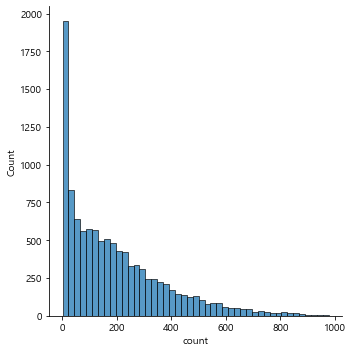

In [19]:
sns.displot(x = 'count', data = train)

왜도가 높기 때문에 변수변환을 해야 할 필요가 있음 
> 로그변환? sqrt? 다양한 방법이 있음

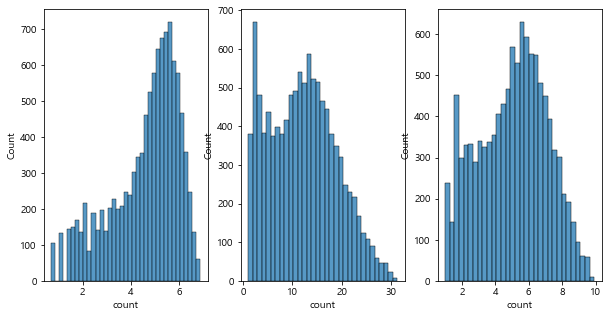

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
sns.histplot(np.log1p(train['count']), ax = ax[0])
sns.histplot(np.sqrt(train['count']), ax = ax[1])
sns.histplot(np.cbrt(train['count']), ax = ax[2])
plt.show()

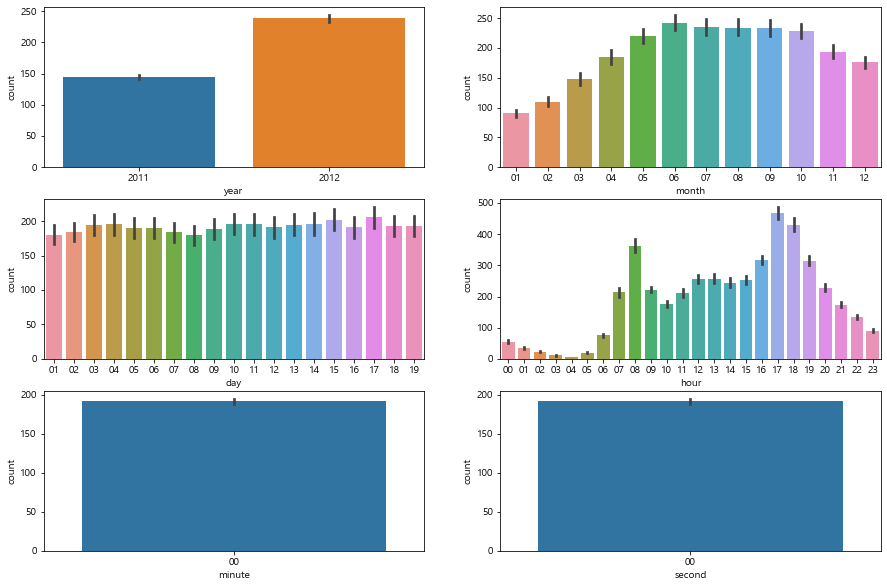

In [21]:
fig, ax = plt.subplots(3, 2, figsize = (15, 10))
sns.barplot(x = 'year', y = 'count', data = train, ax = ax[0, 0])
sns.barplot(x = 'month', y = 'count', data = train, ax = ax[0, 1])
sns.barplot(x = 'day', y = 'count', data = train, ax = ax[1, 0])
sns.barplot(x = 'hour', y = 'count', data = train, ax = ax[1, 1])
sns.barplot(x = 'minute', y = 'count', data = train, ax = ax[2, 0])
sns.barplot(x = 'second', y = 'count', data = train, ax = ax[2, 1])
plt.show()

- 1. 2011년보다 2012년에 대여 수량이 더 많았음
- 2. 월별 대여 수량에는 추세가 있다. 날씨가 따뜻할수록 대여 수량이 많다고 볼 수 있음
- 3. 일별 대여 수량에는 뚜렷한 추세가 없다고 판단할 수 있고, 훈련 데이터에는 1~19일, 테스트 데이터에는 20일~ 이기 때문에 겹치는 부분이 없어서 사용할 수 없음
- 4. 시간대에 따른 추세가 있다. 출퇴근(등하교)시간에 많이 이용한다고 볼 수 있음
    - 새벽 시간에는 이용자의 수가 거의 없는 것이 당연하다
- 5. 분, 초는 00만 있기 때문에 필요없음 

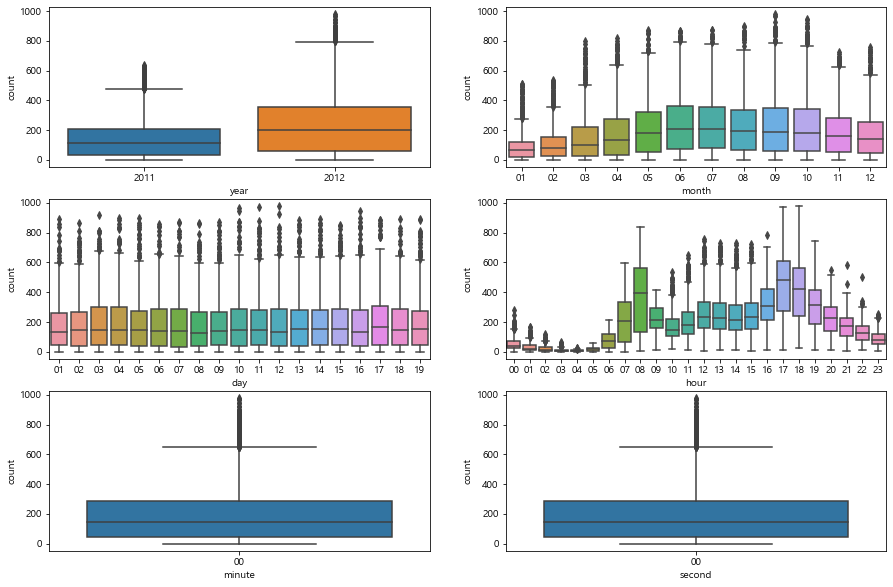

In [22]:
fig, ax = plt.subplots(3, 2, figsize = (15, 10))
sns.boxplot(x = 'year', y = 'count', data = train, ax = ax[0, 0])
sns.boxplot(x = 'month', y = 'count', data = train, ax = ax[0, 1])
sns.boxplot(x = 'day', y = 'count', data = train, ax = ax[1, 0])
sns.boxplot(x = 'hour', y = 'count', data = train, ax = ax[1, 1])
sns.boxplot(x = 'minute', y = 'count', data = train, ax = ax[2, 0])
sns.boxplot(x = 'second', y = 'count', data = train, ax = ax[2, 1])
plt.show()

**계절, 날씨, 공휴일, 근무일별 대여 수량 확인**

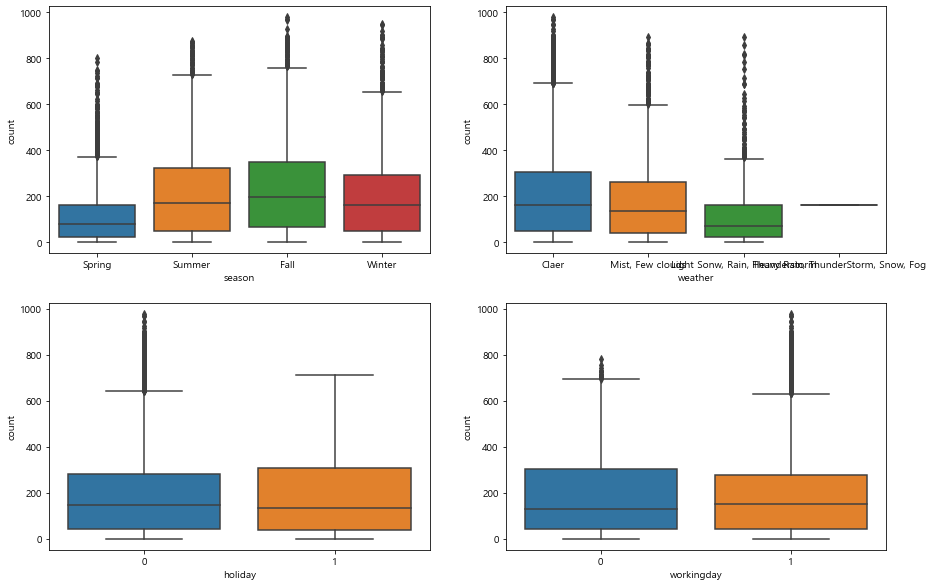

In [23]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
sns.boxplot(x = 'season', y = 'count', data = train, ax = ax[0, 0])
sns.boxplot(x = 'weather', y = 'count', data = train, ax = ax[0, 1])
sns.boxplot(x = 'holiday', y = 'count', data = train, ax = ax[1, 0])
sns.boxplot(x = 'workingday', y = 'count', data = train, ax = ax[1, 1])
plt.show()

x축 라벨 겹침 현상을 해결하기 위해 labelrotation 수행

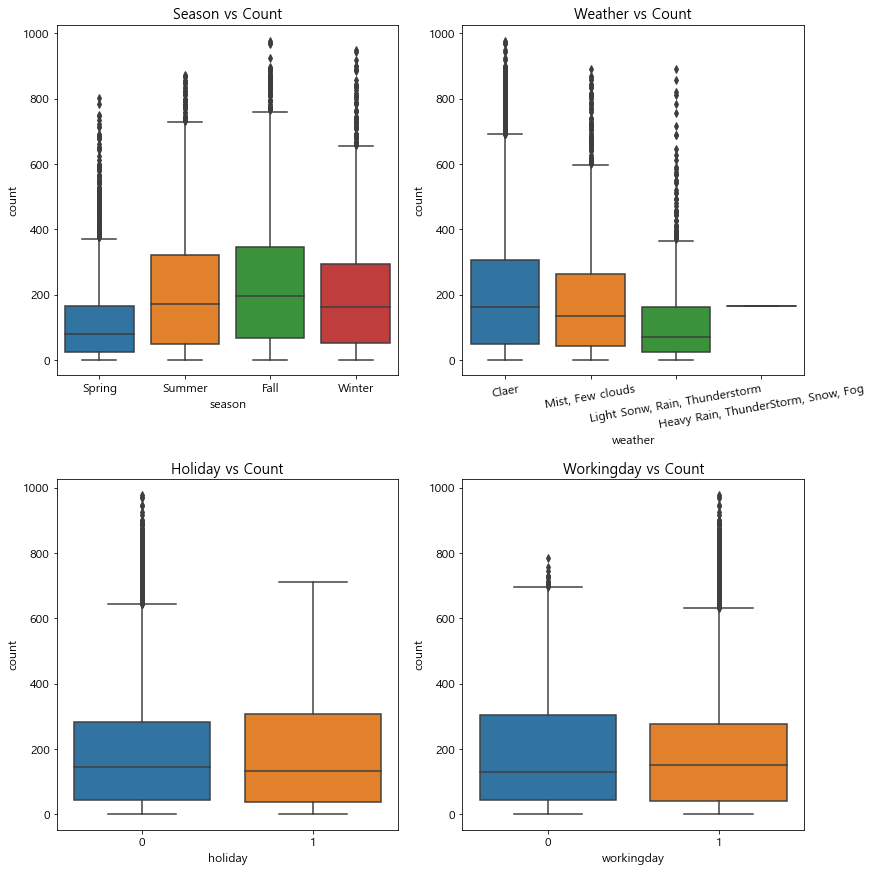

In [24]:
mpl.rc('font', size = 12)
fig, ax = plt.subplots(2, 2, figsize = (15, 10), constrained_layout = True)
fig.set_size_inches(12, 12)

sns.boxplot(x = 'season', y = 'count', data = train, ax = ax[0, 0])
sns.boxplot(x = 'weather', y = 'count', data = train, ax = ax[0, 1])
sns.boxplot(x = 'holiday', y = 'count', data = train, ax = ax[1, 0])
sns.boxplot(x = 'workingday', y = 'count', data = train, ax = ax[1, 1])

ax[0,0].set(title = 'Season vs Count')
ax[0,1].set(title = 'Weather vs Count')
ax[1,0].set(title = 'Holiday vs Count')
ax[1,1].set(title = 'Workingday vs Count')

ax[0,1].tick_params(axis = 'x', labelrotation = 10)

**근무일 여부, 공휴일 여부, 주말 여부, 계절, 날씨에 따른 시간별 사용자 수**

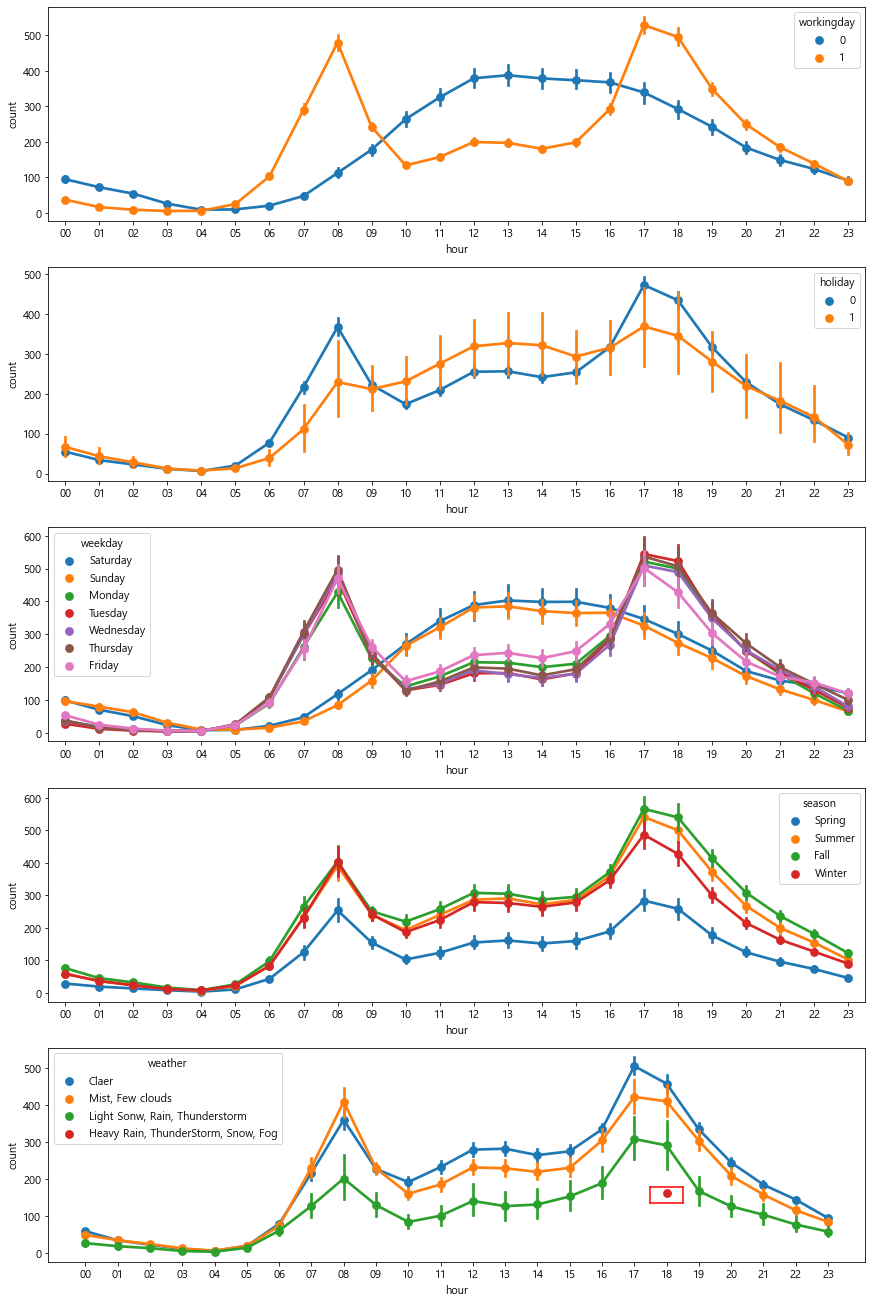

In [25]:
mpl.rc('font', size = 11)
fig, ax = plt.subplots(5, 1, constrained_layout = True)
fig.set_size_inches(12, 18)

sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'workingday', ax = ax[0])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'holiday', ax = ax[1])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weekday', ax = ax[2])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'season', ax = ax[3])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weather', ax = ax[4])
plt.plot([17.5, 18.5], [135,  135], color = 'red')
plt.plot([17.5, 18.5], [180,  180], color = 'red')
plt.plot([17.5, 17.5], [135,  180], color = 'red')
plt.plot([18.5, 18.5], [135,  180], color = 'red')

- 1. 근무일에는 출퇴근 시간에 대여 수량이 많고, 휴일에는 12~2시 사이가 가장 대여 수량이 많다
- 2. 공휴일, 요일에 따른 대여 수량의 추세도 비슷한 것을 알 수 있다.
- 3. 가을에 가장 많고 봄에 가장 적다
- 4. 날씨가 좋을수록 이용객이 많은 것을 알 수 있다. 
    - 폭우, 천둥번개, 눈, 안개(4)의 경우에 이용자 수가 있는데 이유를 확인해봐야 함 

In [26]:
train[train['weather'] == 'Heavy Rain, ThunderStorm, Snow, Fog']

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
5631,2012-01-09 18:00:00,Spring,0,1,"Heavy Rain, ThunderStorm, Snow, Fog",8.2,11.365,86,6.0032,6,158,164,2012-01-09,2012,01,09,18,00,00,Monday


이상치라고 판단하고 제거를 고려해보는 것도 좋은 방법

**온도, 체감온도, 풍속, 습도에 따른 대여 수량을 `regplot`을 이용해서 표현**

<AxesSubplot:xlabel='humidity', ylabel='count'>

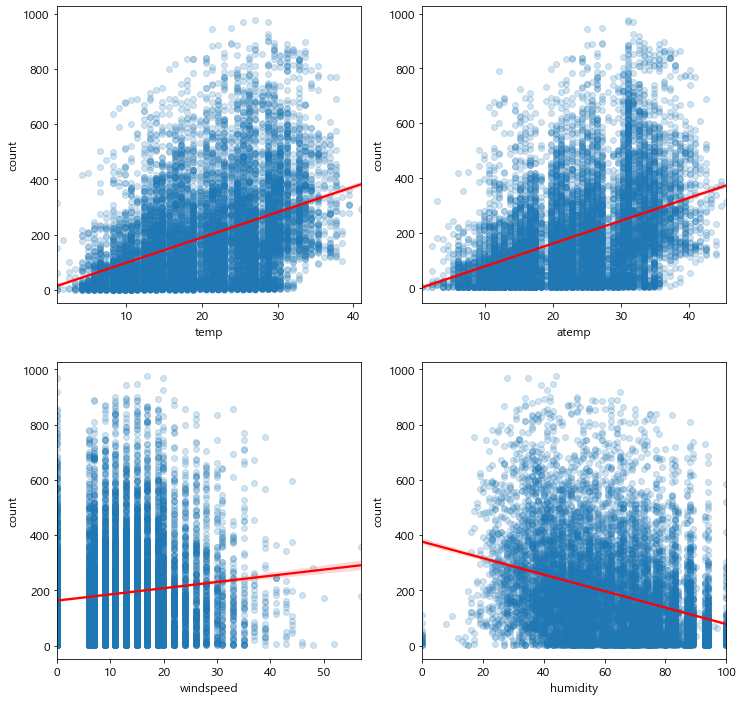

In [27]:
mpl.rc('font', size = 12)
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 12)

sns.regplot(x = 'temp', y = 'count', data = train, ax = ax[0, 0],
           scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'red'})
sns.regplot(x = 'atemp', y = 'count', data = train, ax = ax[0, 1],
           scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'red'})
sns.regplot(x = 'windspeed', y = 'count', data = train, ax = ax[1, 0],
           scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'red'})
sns.regplot(x = 'humidity', y = 'count', data = train, ax = ax[1, 1],
           scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'red'})


- 1. 온도와 체감온도가 높을수록 대여 수량이 많다
- 2. 습도가 낮을수록 대여수량이 많다
- 3. windspeed가 높아질수록 대여 수량이 많은데 상식과는 다른 결과임
    - 풍속이 0인 데이터가 많다. 
    - 풍속이 0인 데이터가 오류에 의한 것인지, 실제 풍속이 0이었는지 확인해보고 불가능하다면 삭제하는 것도 고려해야 한다.
    - 삭제

**weather 변수를 3\~5 : 1, 6\~8 : 2, 9\~11 : 3, 12,1,2 : 4로 바꾸는 것도 좋은 방법**

<AxesSubplot:xlabel='hour', ylabel='count'>

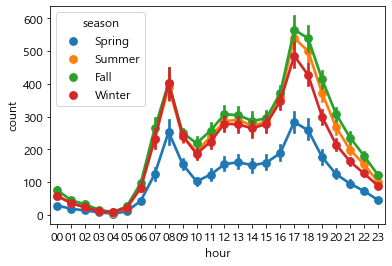

In [29]:
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'season')

<AxesSubplot:xlabel='month', ylabel='temp'>

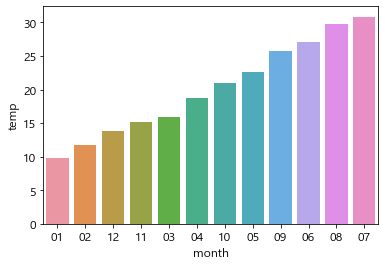

In [28]:
temp_by_month = train.groupby('month')['temp'].mean().to_frame().sort_values(by = 'temp')
sns.barplot(x = temp_by_month.index, y = 'temp', data = temp_by_month)

In [31]:
def convert_season(month) :
    if month in ['03','04','05'] :
        return 'Spring'
    elif month in ['06','07','08'] : 
        return 'Summer'
    elif month in ['09','10','11'] : 
        return 'Fall'
    else :
        return 'Winter'
        

In [33]:
train['season2'] = train['month'].apply(convert_season)

<AxesSubplot:xlabel='hour', ylabel='count'>

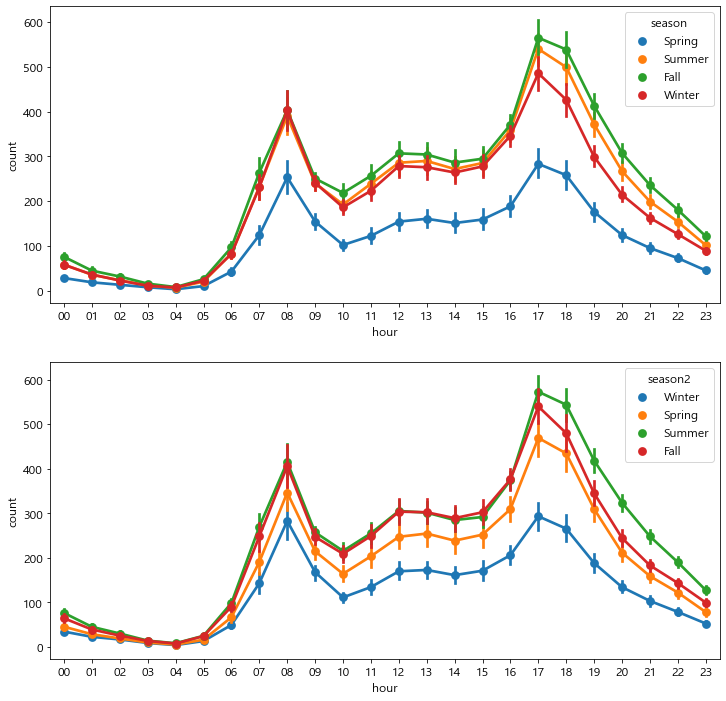

In [35]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(12, 12)
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'season', ax = ax[0])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'season2', ax = ax[1])

In [37]:
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


[Text(0.5, 1.0, 'Heatmap')]

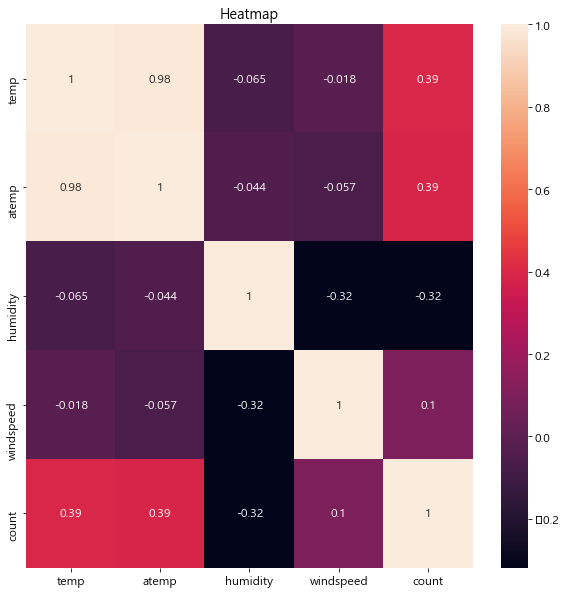

In [47]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr(),
           annot = True)
ax.set(title = 'Heatmap')